In [52]:
#Load packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
%matplotlib inline
import seaborn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.datasets import make_classification
import statsmodels.api as sm
import functools as ft
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

In [2]:
#Import data
data = pd.read_csv('LoansTrainingSet.csv')

C:\Users\Magu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Explore data

#data.head()

#data.describe()
    #Credit Score max greater than 800
    #Annual Income min $0
    #Number of Open Accounts max is 76

#print(data['Term'].unique())
    #Spelling differences / Punctuation format

data.info()
    #Total entries = 256984
    #Annual Income = 195308
    #Months since last delinquent = 116601
    #Bankruptcies = 256455
    #Tax Liens = 256961
    #Credit Score = 195308
    
    #Monthly Debt is object
    #Maximum Open Credit is object
    
#Duplicate rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256984 entries, 0 to 256983
Data columns (total 19 columns):
Loan ID                         256984 non-null object
Customer ID                     256984 non-null object
Loan Status                     256984 non-null object
Current Loan Amount             256984 non-null int64
Term                            256984 non-null object
Credit Score                    195308 non-null float64
Years in current job            256984 non-null object
Home Ownership                  256984 non-null object
Annual Income                   195308 non-null float64
Purpose                         256984 non-null object
Monthly Debt                    256984 non-null object
Years of Credit History         256984 non-null float64
Months since last delinquent    116601 non-null float64
Number of Open Accounts         256984 non-null int64
Number of Credit Problems       256984 non-null int64
Current Credit Balance          256984 non-null int64
Maximum O

In [4]:
#Duplicate rows

#Sort rows based on ascending number of NaN 
data = data.iloc[data.isnull().sum(1).sort_values(ascending=True).index]

#Remove Duplicates based on Loan ID
data = data.drop_duplicates(['Loan ID'], keep='last')

#Reset dataframe indices
data = data.reset_index(drop=True)

In [5]:
#Spelling differences / Punctuation format

#print(data['Credit Score'].unique())

#Loan Status - ['Fully Paid' 'Charged Off']
#Term - ['Short Term' 'Long Term']
#Years in current job - ['10+ years' '4 years' '6 years' '5 years' 'n/a' '3 years' '2 years' '< 1 year' '1 year' '7 years' '9 years' '8 years']
    #Address 'n/a' and remove 'years','+','<' etc
    #Convert to ordinal
#Home Ownership - ['Home Mortgage' 'Own Home' 'Rent' 'HaveMortgage']
    #'Home Mortgage' and 'HaveMortgage'
#Purpose - ['Debt Consolidation' 'other' 'Business Loan' 'Home Improvements' 'Buy House' 'Other' 'Buy a Car' 'Medical Bills' 'Take a Trip' 'Educational Expenses']
    #'other' and 'Other'
#Credit Score - [  741.    nan   687.   744.   727.   730.   747.   719.   711.   690. 7210.  6210.  6690.  6330.  6470.  6190.  6670.  6490.  6760.  6180.
    #4 digit credit scores - extra 0

#Replace Home Ownership 'HaveMortgage' with 'Home Mortgage'
data.replace({'HaveMortgage':'Home Mortgage'},inplace=True)
    
#Replace Purpose 'other' with 'Other'
data.replace({'other':'Other'},inplace=True)

#Revome extra '0' at the end of credit score
for i in range(0,len(data)):
    if data['Credit Score'].get_value(i) > 800 and np.isnan(data['Credit Score'].get_value(i)) == False:
        new_score = (data['Credit Score'].get_value(i))/10
        data.set_value(i,['Credit Score'],new_score)


In [6]:
#Convert Monthly Debt and Maximum Open Credit data to float

#Remove commas and '$' from Monthly Debt
data[['Monthly Debt']] = data[['Monthly Debt']].replace({'\$': '',',': ''}, regex=True)

#Remove '#VALUE!' from Maximum Open Credit
data[['Maximum Open Credit']] = data[['Maximum Open Credit']].replace('#VALUE!', '')
    
#Convert Monthly Debt and Maximum Open Credit data from string to float
data['Monthly Debt'] = pd.to_numeric(data['Monthly Debt'])
data['Maximum Open Credit'] = pd.to_numeric(data['Maximum Open Credit'])

In [7]:
#Remove strings from Years in current job
#['10+ years' '4 years' '6 years' '5 years' 'n/a' '3 years' '2 years' 
    #'< 1 year' '1 year' '7 years' '9 years' '8 years']
    
#List of strings to remove: '+', ' years', '< ', ' year'
data[['Years in current job']] = data[['Years in current job']].replace('10+ years', '10')
data[['Years in current job']] = data[['Years in current job']].replace(' years', '',regex=True)
data[['Years in current job']] = data[['Years in current job']].replace('< ', '',regex=True)
data[['Years in current job']] = data[['Years in current job']].replace(' year', '',regex=True)

In [8]:
data.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,2.157000e+05,156544.000000,1.565440e+05,215700.000000,215700.000000,97438.000000,215700.000000,215700.000000,2.157000e+05,2.156980e+05,215248.000000,215678.000000
mean,1.633515e+07,723.911322,7.349255e+04,960.395471,18.359758,35.031949,11.077566,0.155424,1.545718e+04,3.698378e+04,0.110556,0.026331
std,3.695307e+07,26.086905,5.854577e+04,634.783876,7.057999,21.810714,4.971825,0.457972,1.975035e+04,6.011805e+05,0.336853,0.240853
min,5.050000e+02,585.000000,4.033000e+03,0.000000,3.400000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.328750e+03,714.000000,4.505400e+04,527.640000,13.600000,17.000000,8.000000,0.000000,5.932000e+03,1.296100e+04,0.000000,0.000000
50%,1.464200e+04,732.000000,6.309450e+04,840.550000,17.000000,32.000000,10.000000,0.000000,1.104200e+04,2.206000e+04,0.000000,0.000000
75%,2.520800e+04,742.000000,8.860500e+04,1249.927500,21.800000,51.000000,14.000000,0.000000,1.932400e+04,3.680975e+04,0.000000,0.000000
max,1.000000e+08,751.000000,8.713547e+06,22939.120000,70.500000,176.000000,76.000000,11.000000,1.731412e+06,1.763322e+08,7.000000,11.000000


In [9]:
#Missing data

#Bankruptcies - [  0.   1.   2.   3.  nan   4.   6.   5.   7.]
    #Bankruptcy removed from credit report after 7 years
        #Replace NaN values with 0
for i in range(0,len(data)):
    if np.isnan(data['Bankruptcies'].get_value(i)) == True:
        data.set_value(i,['Bankruptcies'],0)

#Tax Liens - [  0.   2.   5.   1.   3.  nan   4.  11.   8.   6.   7.  10.   9.]
    #Tax Liens removed from credit report after 10 years
        #Replace NaN values with 0
for i in range(0,len(data)):
    if np.isnan(data['Tax Liens'].get_value(i)) == True:
        data.set_value(i,['Tax Liens'],0)

#Annual Income - [  33694.      nan  246025. ...,  102879.   36568.   25305.]
    #Assuming NaN annual income is retiree or no income
        #Replace NaN with 0
for i in range(0,len(data)):
    if np.isnan(data['Annual Income'].get_value(i)) == True:
        data.set_value(i,['Annual Income'],0)

#Months since last delinquent - 67.   94.   nan   93.   83.  115.   87.   99.  151.   88.  130.  101.
    #Assuming NaN is for accounts that have never been delinquent.
    #Replace NaN with 12*Years of Credit History
for i in range(0,len(data)):
    if np.isnan(data['Months since last delinquent'].get_value(i)) == True:
        new_months = round((data['Years of Credit History'].get_value(i))*12)
        data.set_value(i,['Months since last delinquent'],new_months)

#Maximum Open Credit missing values due to data cleaning above
for i in range(0,len(data)):
    if np.isnan(data['Maximum Open Credit'].get_value(i)) == True:
        new_max = data['Maximum Open Credit'].median()
        data.set_value(i,['Maximum Open Credit'],new_max)

In [10]:
#Credit Score - [  741.    nan   687.   744.   727.   730.   747.   719.   711.   690.
    #Determine missing credit scores with linear regression
    #Regression based on Months since last delinquent, Current Credit Balance, Max Open Credit, and Years of Credit History
    
#Separate data into train and test sets
train = data[np.isnan(data['Credit Score']) == False]
test_for_pred = data[np.isnan(data['Credit Score']) == True]

#Lasso regression to estimate Credit Score
y = train[['Credit Score']]
x = train[['Months since last delinquent','Current Credit Balance','Maximum Open Credit','Years of Credit History']]
x = sm.add_constant(x)
lassoreg = linear_model.Lasso()
lassoreg.fit(x,y)

x_test_for_pred = test_for_pred[['Months since last delinquent','Current Credit Balance','Maximum Open Credit','Years of Credit History']]
x_test_for_pred = sm.add_constant(x_test_for_pred)
y_pred_lasso = lassoreg.predict(x_test_for_pred)

#Replace NaN Credit Score with predicted values from Lasso regression
d = 0
for i in range(0,len(data)):
    if np.isnan(data['Credit Score'].get_value(i)) == True:
        data.set_value(i,['Credit Score'],y_pred_lasso[d])
        d = d + 1

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215700 entries, 0 to 215699
Data columns (total 19 columns):
Loan ID                         215700 non-null object
Customer ID                     215700 non-null object
Loan Status                     215700 non-null object
Current Loan Amount             215700 non-null int64
Term                            215700 non-null object
Credit Score                    215700 non-null float64
Years in current job            215700 non-null object
Home Ownership                  215700 non-null object
Annual Income                   215700 non-null float64
Purpose                         215700 non-null object
Monthly Debt                    215700 non-null float64
Years of Credit History         215700 non-null float64
Months since last delinquent    215700 non-null float64
Number of Open Accounts         215700 non-null int64
Number of Credit Problems       215700 non-null int64
Current Credit Balance          215700 non-null int64
Maximum 

In [12]:
#Feature Engineering

#Current credit balance to max available credit ratio
#x1 = pd.DataFrame(data['Current Credit Balance']/data['Maximum Open Credit'],columns=['x1'])
    #Divide by zero error
#data = pd.concat([x1,data],axis = 1)

In [28]:
#Convert to categorical using get_dummies 
dum_list = ['Term','Years in current job','Home Ownership','Purpose']
prefix_list = ['Term','Years','Ownership','Purpose']
merged_data_dums = pd.DataFrame(data['Loan Status']) #,'Credit Score','Annual Income','Monthly Debt','Years of Credit History','Months since last delinquent','Number of Open Accounts','Number of Credit Problems','Current Credit Balance','Maximum Open Credit','Bankruptcies','Tax Liens'])

for col in range(len(dum_list)):
    dums = pd.get_dummies(data[dum_list[col]].astype('category'), prefix = prefix_list[col], drop_first=True)
    merged_data_dums = merged_data_dums.join(dums)

data1 = data.drop(['Loan Status'],axis=1)
x = pd.concat([data1,merged_data_dums],axis=1)

In [29]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215700 entries, 0 to 215699
Data columns (total 40 columns):
Loan ID                         215700 non-null object
Customer ID                     215700 non-null object
Current Loan Amount             215700 non-null int64
Term                            215700 non-null object
Credit Score                    215700 non-null float64
Years in current job            215700 non-null object
Home Ownership                  215700 non-null object
Annual Income                   215700 non-null float64
Purpose                         215700 non-null object
Monthly Debt                    215700 non-null float64
Years of Credit History         215700 non-null float64
Months since last delinquent    215700 non-null float64
Number of Open Accounts         215700 non-null int64
Number of Credit Problems       215700 non-null int64
Current Credit Balance          215700 non-null int64
Maximum Open Credit             215700 non-null float64
Bankrup

In [40]:
#Convert 'Loan Status' to integers 
ls = data[['Loan Status']]
ls = pd.DataFrame(ls)
ls.name ='Loan Status'
lsmap = {'Fully Paid':1,'Charged Off':0}
ls = ls.applymap(lambda s:lsmap.get(s) if s in lsmap else s)

In [62]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(x,ls,train_size = 0.7, random_state=0)
test_Loan_ID = x_test['Loan ID']
x_train = x_train.drop(['Loan ID','Customer ID','Loan Status','Term','Years in current job','Home Ownership','Purpose'],axis=1)
x_test = x_test.drop(['Loan ID','Customer ID','Loan Status','Term','Years in current job','Home Ownership','Purpose'],axis=1)


C:\Users\Magu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [50]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64710 entries, 207178 to 35928
Data columns (total 33 columns):
Current Loan Amount             64710 non-null int64
Credit Score                    64710 non-null float64
Annual Income                   64710 non-null float64
Monthly Debt                    64710 non-null float64
Years of Credit History         64710 non-null float64
Months since last delinquent    64710 non-null float64
Number of Open Accounts         64710 non-null int64
Number of Credit Problems       64710 non-null int64
Current Credit Balance          64710 non-null int64
Maximum Open Credit             64710 non-null float64
Bankruptcies                    64710 non-null float64
Tax Liens                       64710 non-null float64
Term_Short Term                 64710 non-null uint8
Years_10                        64710 non-null uint8
Years_2                         64710 non-null uint8
Years_3                         64710 non-null uint8
Years_4               

In [59]:
#Random Forest classifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(mean_squared_error(y_test, y_pred)**0.5)
print(r2_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred)) #Percent of correct predictions

C:\Users\Magu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.454888113492
-0.382092492713
0.793076804203


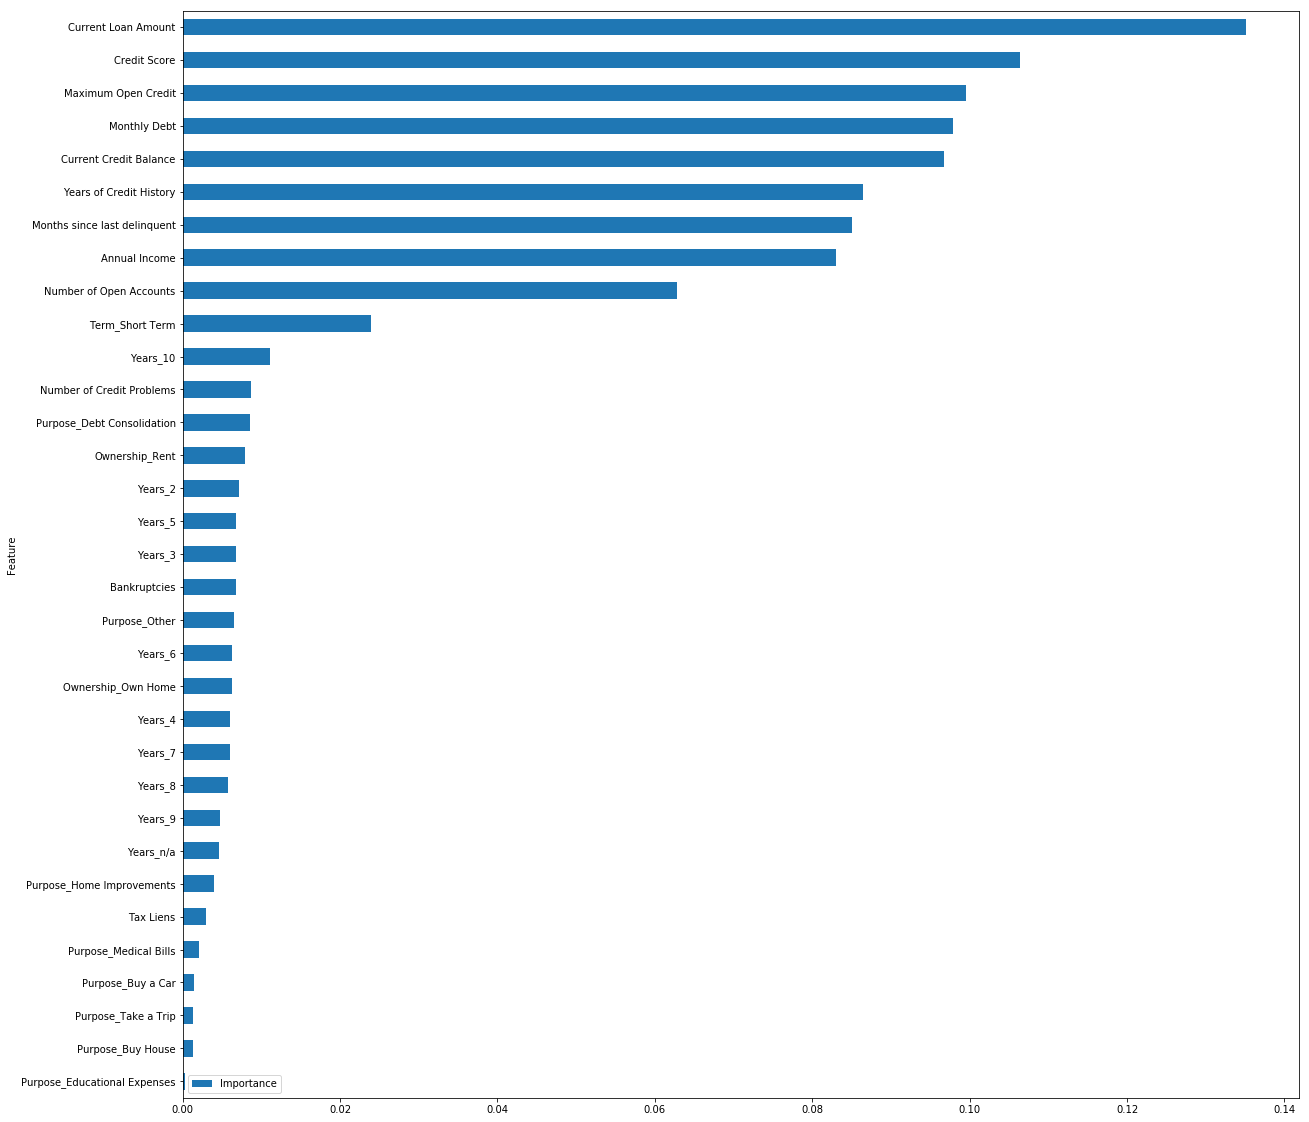

In [54]:
#Feature Importance based on Random Forest
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = clf.feature_importances_
features.sort_values(by=['Importance'],ascending=True,inplace=True)
features.set_index('Feature',inplace=True)
features.plot(kind='barh',figsize=(20,20))

In [55]:
#Gradient Boosting Classifier
clf = GradientBoostingClassifier()
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(mean_squared_error(y_test, y_pred)**0.5)
print(r2_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred)) #Percent of corrent predictions

C:\Users\Magu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.426882189424
-0.21714971427
0.817771596353


In [56]:
#Precision and Recall (Confusion Matrix)
conf = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=['Fully Paid','Charged Off'])
        
prec = precision_score(y_test,y_pred,labels=None,pos_label=1,average=None,sample_weight=None)
#[ 0.55453149,  0.82044678]

rec = recall_score(y_test,y_pred,labels=None,pos_label=1,average=None,sample_weight=None)
#[ 0.03043075,  0.99451246]

#Calculate Probability of classification
prob = clf.predict_proba(x_test)

conf #columns = predicted, rows = actual

,Fully Paid,Charged Off
0,361,11502
1,290,52557


In [60]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64710 entries, 207178 to 35928
Data columns (total 33 columns):
Current Loan Amount             64710 non-null int64
Credit Score                    64710 non-null float64
Annual Income                   64710 non-null float64
Monthly Debt                    64710 non-null float64
Years of Credit History         64710 non-null float64
Months since last delinquent    64710 non-null float64
Number of Open Accounts         64710 non-null int64
Number of Credit Problems       64710 non-null int64
Current Credit Balance          64710 non-null int64
Maximum Open Credit             64710 non-null float64
Bankruptcies                    64710 non-null float64
Tax Liens                       64710 non-null float64
Term_Short Term                 64710 non-null uint8
Years_10                        64710 non-null uint8
Years_2                         64710 non-null uint8
Years_3                         64710 non-null uint8
Years_4               

In [63]:
#Output csv
#CSV file with the location of the tower, followed by the classified fault_severity,
#& if possible (check the sample project), the probabilities of the different fault_severity.

sub = pd.DataFrame(OrderedDict({'Loan ID': test_Loan_ID,'Loan Status':y_pred,
    'prob of Fully Paid':prob[:,0],'prob of Charged Off':prob[:,1]}))

sub.to_csv('loan_prediction_v3.csv', index=False)